<a href="https://colab.research.google.com/github/AJAV-TIP/ApplicationExample/blob/main/Calibration__example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Example of calibration using a known volume

Import common libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

!pip install -U scikit-learn
from sklearn.metrics import r2_score

Import library to obtain compressibility factor or other thermodynamic properties from an Equation of State (EoS)

In [2]:
!pip install CoolProp
import CoolProp.CoolProp as CP

  Read pressure sensor data from a CSV file hosted in a public GitHub repository and store it in the objects `Pf` (Final Pressure) and `Pi` (Initial Pressure)

In [3]:
urlWKV = ('https://raw.githubusercontent.com/AJAV-TIP/ApplicationExample/main/CalData_with_known_volume.csv')
urlSV = ('https://raw.githubusercontent.com/AJAV-TIP/ApplicationExample/main/CalData_without_known_volume.csv')
dfWKV = pd.read_csv(urlWKV) # data frame for the measurements with known volume
dfSV = pd.read_csv(urlSV) #data frame for the  system volume mesurements

Describe the known volume

In [4]:
n = 3 # number of elements (3 spheres)
r = 0.4625/2 # sphere diameter
Vesf = 4/3*np.pi*r**3
Vk = 3*Vesf # Known volume
Vk

0.15540145769754277

Calculate compresibility factors

In [5]:
dfZSV = pd.DataFrame(index=range(len(dfSV)),columns=['Zi_ref','Zeq_ref', 'Zeq_ana',	'Zi_ana'])
dfZWKV = pd.DataFrame(index=range(len(dfWKV)),columns=['Zi_ref','Zeq_ref', 'Zeq_ana',	'Zi_ana'])

for i in range(0,len(dfWKV)):
  dfZSV.Zi_ref[i] = (CP.PropsSI('Z', 'T', dfSV.Tref[i] , 'P', dfSV.Pi_Vref[i]*1e6, 'Hydrogen'))
  dfZSV.Zeq_ref[i] = (CP.PropsSI('Z', 'T', dfSV.Tref[i] , 'P', dfSV.Peq_Vtotal[i]*1e6, 'Hydrogen'))
  dfZSV.Zeq_ana[i] = (CP.PropsSI('Z', 'T', dfSV.Tana[i] , 'P', dfSV.Peq_Vtotal[i]*1e6, 'Hydrogen'))
  dfZSV.Zi_ana[i] = (CP.PropsSI('Z', 'T', dfSV.Tana[i] , 'P', dfSV.Pi_Vana[i]*1e6, 'Hydrogen'))

  dfZWKV.Zi_ref[i] = (CP.PropsSI('Z', 'T', dfWKV.Tref[i] , 'P', dfWKV.Pi_Vref[i]*1e6, 'Hydrogen'))
  dfZWKV.Zeq_ref[i] = (CP.PropsSI('Z', 'T', dfWKV.Tref[i] , 'P', dfWKV.Peq_Vtotal[i]*1e6, 'Hydrogen'))
  dfZWKV.Zeq_ana[i] = (CP.PropsSI('Z', 'T', dfWKV.Tana[i] , 'P', dfWKV.Peq_Vtotal[i]*1e6, 'Hydrogen'))
  dfZWKV.Zi_ana[i] = (CP.PropsSI('Z', 'T', dfWKV.Tana[i] , 'P', dfWKV.Pi_Vana[i]*1e6, 'Hydrogen'))

Calculate X and Y vectors

In [6]:
dfXYSV = pd.DataFrame(index=range(len(dfSV)),columns=['X','Y'])
dfXYWKV = pd.DataFrame(index=range(len(dfWKV)),columns=['X','Y'])

for i in range(0,len(dfWKV)):
  dfXYSV.X[i] = ((1/dfSV.Tana[i])*((dfSV.Peq_Vtotal[i]/dfZSV.Zeq_ana[i])-(dfSV.Pi_Vana[i]/dfZSV.Zi_ana[i])))
  dfXYSV.Y[i] = ((1/dfSV.Tref[i])*((dfSV.Pi_Vref[i]/dfZSV.Zi_ref[i])-(dfSV.Peq_Vtotal[i]/dfZSV.Zeq_ref[i])))

  dfXYWKV.X[i] = ((1/dfWKV.Tana[i])*((dfWKV.Peq_Vtotal[i]/dfZWKV.Zeq_ana[i])-(dfWKV.Pi_Vana[i]/dfZWKV.Zi_ana[i])))
  dfXYWKV.Y[i] = ((1/dfWKV.Tref[i])*((dfWKV.Pi_Vref[i]/dfZWKV.Zi_ref[i])-(dfWKV.Peq_Vtotal[i]/dfZWKV.Zeq_ref[i])))


calculate K parameters and determinarion coefficients

In [7]:
KSV = np.sum(dfXYSV.X*dfXYSV.Y)/np.sum(dfXYSV.X**2)
KWSV = np.sum(dfXYWKV.X*dfXYWKV.Y)/np.sum(dfXYWKV.X**2)
R2SV = r2_score(dfXYSV.Y,dfXYSV.X*KSV)
R2WKV = r2_score(dfXYWKV.Y,dfXYWKV.X*KWSV)

Calculate calibrated refrence volume

In [8]:
Vref = Vk/(KSV-KWSV)
Vref # mL

154.72133855469812

Calculate volume of sample cell

In [9]:
Vana = Vref * KSV
Vana # mL

5.037877889252887

Show the calibraion figure

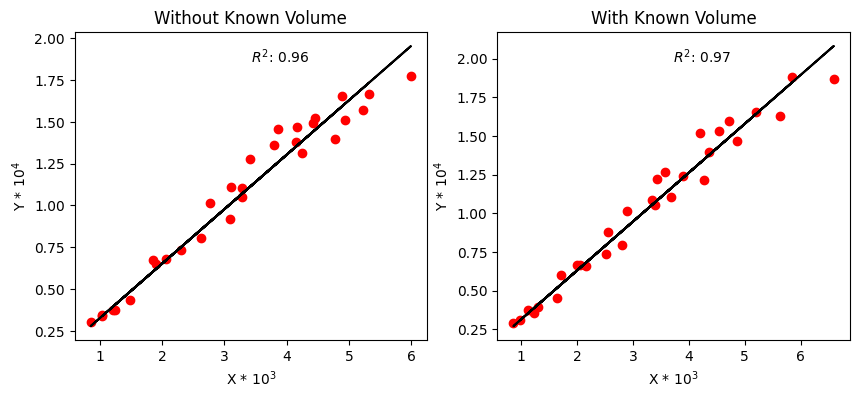

In [10]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))  # 1 fila, 2 columnas


ax1.set_title('Without Known Volume')
ax1.set_xlabel('X * $10^3$')
ax1.set_ylabel('Y * $10^4$')
ax1.text(0.5, 0.9, f'$R^2$: {R2SV:.2f}', transform=ax1.transAxes)

ax2.set_title('With Known Volume')
ax2.set_xlabel('X * $10^3$')
ax2.set_ylabel('Y * $10^4$')
ax2.text(0.5, 0.9, f'$R^2$: {R2WKV:.2f}', transform=ax2.transAxes)

ax1.plot(dfXYSV['X']*1000,dfXYSV['Y']*10000,'ro',dfXYSV['X']*1000,dfXYSV['X']*10000*KSV,'k-')
ax2.plot(dfXYWKV['X']*1000,dfXYWKV['Y']*10000,'ro', dfXYWKV['X']*1000, dfXYWKV['X']*10000*KWSV, 'k-')

plt.show()
